<a href="https://colab.research.google.com/github/AliAch04/TensorFlow-projs/blob/main/finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

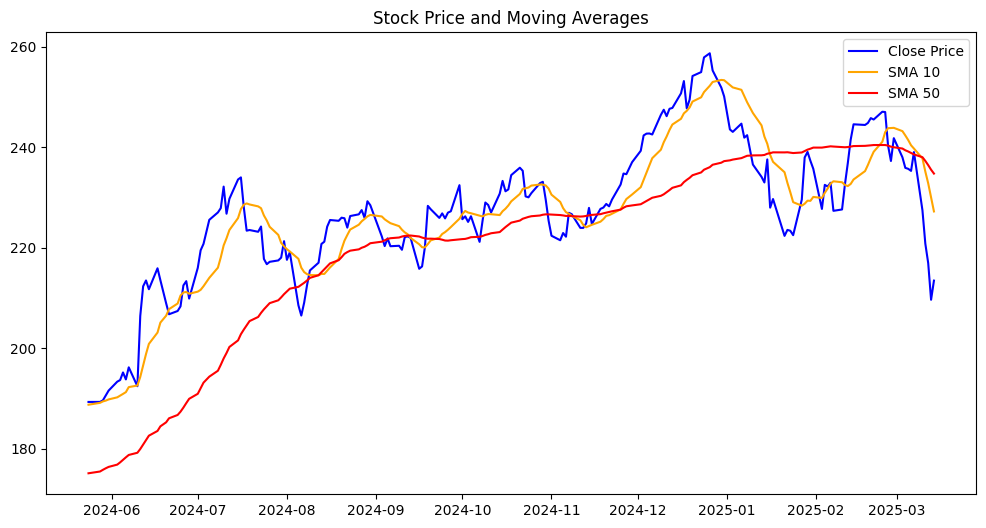

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4642 - loss: 0.6950 - val_accuracy: 0.3659 - val_loss: 0.7119
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6300 - loss: 0.6757 - val_accuracy: 0.3659 - val_loss: 0.7341
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6335 - loss: 0.6659 - val_accuracy: 0.3659 - val_loss: 0.7641
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6222 - loss: 0.6628 - val_accuracy: 0.3659 - val_loss: 0.7858
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5763 - loss: 0.6807 - val_accuracy: 0.3659 - val_loss: 0.7908
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6519 - loss: 0.6484 - val_accuracy: 0.3659 - val_loss: 0.8034
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5701 - loss: 0.6908 - val_accuracy: 0.3659 - val_loss: 0.7903
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6291 - loss: 0.6568 - val_accuracy: 0.3659 - val_loss: 0.

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

def get_stock_data(ticker, period="1y", interval="1d"):
    stock = yf.Ticker(ticker)
    df = stock.history(period=period, interval=interval)
    return df

def get_interest_rate():
    # Exemple statique, à remplacer par une API si besoin
    return 5.0  # Taux d'intérêt fictif en pourcentage

def add_technical_indicators(df):
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['RSI'] = compute_rsi(df['Close'], 14)
    df['MACD'], df['Signal_Line'] = compute_macd(df['Close'])
    df['Interest_Rate'] = get_interest_rate()  # Ajout du taux d'intérêt
    df.dropna(inplace=True)
    return df

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def generate_labels(df):
    df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
    return df

def plot_stock_data(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Close Price', color='blue')
    plt.plot(df.index, df['SMA_10'], label='SMA 10', color='orange')
    plt.plot(df.index, df['SMA_50'], label='SMA 50', color='red')
    plt.legend()
    plt.title('Stock Price and Moving Averages')
    plt.show()

def train_model(df):
    features = ['SMA_10', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'Interest_Rate']
    X = df[features].values.reshape((df.shape[0], 1, len(features)))
    y = df['Target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(1, len(features))),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    return model

def predict_decision(model, df):
    latest_data = df.iloc[-1][['SMA_10', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'Interest_Rate']].values.reshape((1, 1, -1))
    prediction = model.predict(latest_data)
    decision = "BUY" if prediction[0][0] > 0.5 else "SELL"
    return decision

def main():
    ticker = "AAPL"
    df = get_stock_data(ticker)
    df = add_technical_indicators(df)
    df = generate_labels(df)
    plot_stock_data(df)
    model = train_model(df)
    decision = predict_decision(model, df)
    print(f"Decision for {ticker}: {decision}")


main()